In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "T_CD8_NonNaive"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
Zhang2023_L019_P191126_T0_AAACCTGAGAGTCTGG,Zhang2023,Zhang2023_L019,Zhang2023_P191126_T0,5_GEX_V1,HBV,male,41-50,T_CD8_NonNaive,T_CD8_EM_CX3CR1int
Zhang2023_L019_P191126_T0_AAACCTGAGCACAGGT,Zhang2023,Zhang2023_L019,Zhang2023_P191126_T0,5_GEX_V1,HBV,male,41-50,T_CD8_NonNaive,T_CD8_CM
Zhang2023_L019_P191126_T0_AAACGGGAGCTACCTA,Zhang2023,Zhang2023_L019,Zhang2023_P191126_T0,5_GEX_V1,HBV,male,41-50,T_CD8_NonNaive,T_CD8_CM
Zhang2023_L019_P191126_T0_AAACGGGTCTGCCCTA,Zhang2023,Zhang2023_L019,Zhang2023_P191126_T0,5_GEX_V1,HBV,male,41-50,T_CD8_NonNaive,T_CD8_eff_HOBIT
Zhang2023_L019_P191126_T0_AAAGATGAGTCGCCGT,Zhang2023,Zhang2023_L019,Zhang2023_P191126_T0,5_GEX_V1,HBV,male,41-50,T_CD8_NonNaive,T_CD8_CM_stem
...,...,...,...,...,...,...,...,...,...
Perez2022_L067_HC520_T0_CTTACCGCACCGATAT,Perez2022,Perez2022_L067,Perez2022_HC520_T0,3_GEX_V2,healthy,female,18-30,T_CD8_NonNaive,T_CD8_Mem_cytotoxic
Perez2022_L067_HC520_T0_GTTCTCGCAGGGATTG,Perez2022,Perez2022_L067,Perez2022_HC520_T0,3_GEX_V2,healthy,female,18-30,T_CD8_NonNaive,T_CD8_CM
Perez2022_L067_HC520_T0_TATGCCCAGTACGACG,Perez2022,Perez2022_L067,Perez2022_HC520_T0,3_GEX_V2,healthy,female,18-30,T_CD8_NonNaive,T_CD8_activated


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
9,2,4,0.779428,0.804956,0.627405
3,0,4,0.815341,0.804956,0.656313
12,3,4,0.826983,0.804956,0.665685
13,4,1,0.863685,0.789515,0.681892
6,1,4,0.863685,0.804956,0.695228
0,0,1,0.942735,0.789515,0.744304
15,4,3,0.826983,0.914707,0.756447
7,2,1,0.985514,0.789515,0.778078
14,4,2,0.779428,1.000000,0.779428
10,3,1,1.000000,0.789515,0.789515


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

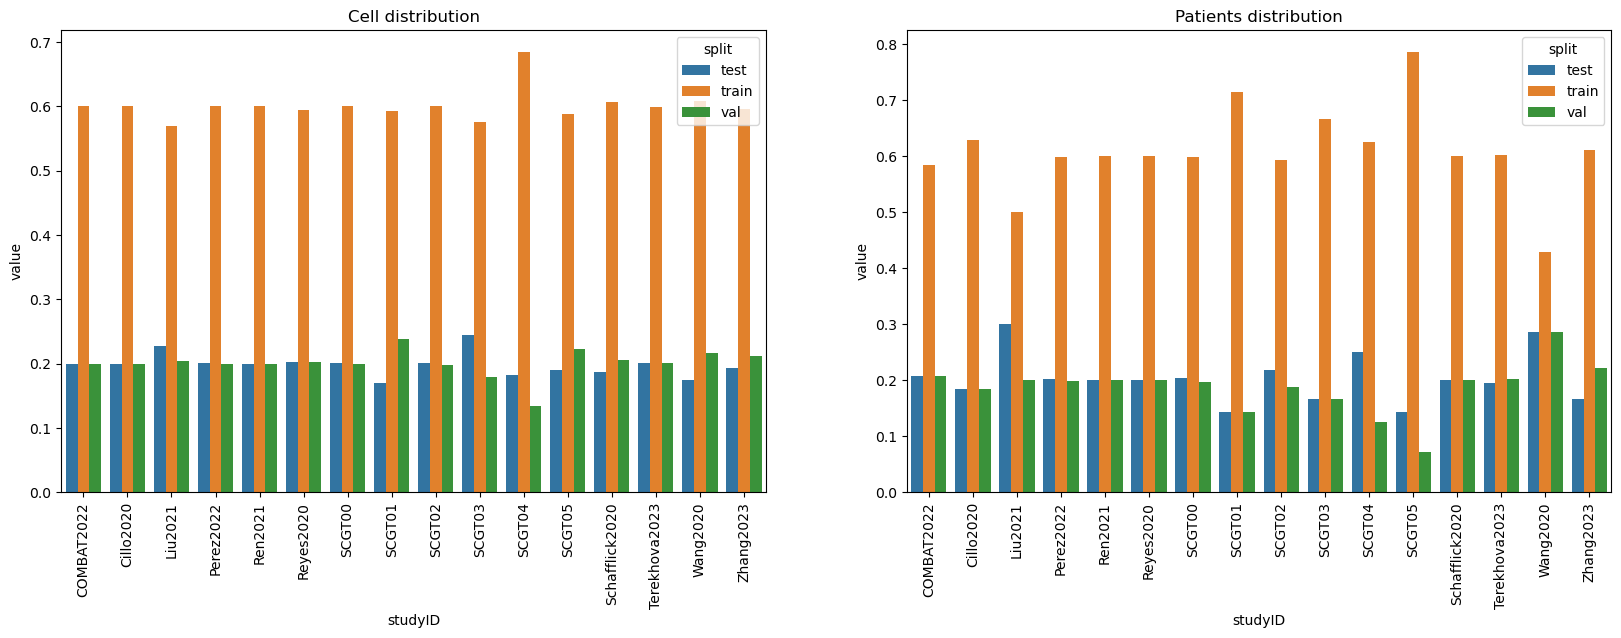

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((313399, 935), (105049, 935), (104874, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((313399,), (105049,), (104874,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-17 18:05:10,479] A new study created in memory with name: no-name-1cb56a03-2d9e-4342-8ec7-9604920ef74b


/tmp/ipykernel_1050222/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250317_180512-s5r8tpdx
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_T_CD8_NonNaive


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/s5r8tpdx


[I 2025-03-17 18:05:34,724] Trial 0 finished with value: -0.900336 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.900336.


[I 2025-03-17 18:05:53,230] Trial 1 finished with value: -0.929279 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.929279.


[I 2025-03-17 18:06:08,406] Trial 2 finished with value: -0.951941 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 2 with value: -0.951941.


[I 2025-03-17 18:06:28,466] Trial 3 finished with value: -0.956348 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 3 with value: -0.956348.


[I 2025-03-17 18:06:52,042] Trial 4 finished with value: -0.928275 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 3 with value: -0.956348.


[I 2025-03-17 18:06:57,151] Trial 5 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:02,308] Trial 6 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:07,894] Trial 7 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:21,654] Trial 8 finished with value: -0.942854 and parameters: {'max_depth': 5, 'min_child_weight': 124, 'subsample': 0.13094966900369656, 'colsample_bynode': 0.9183883618709039, 'learning_rate': 0.004993895014755658}. Best is trial 3 with value: -0.956348.


[I 2025-03-17 18:07:26,480] Trial 9 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:41,944] Trial 10 finished with value: -0.935369 and parameters: {'max_depth': 9, 'min_child_weight': 175, 'subsample': 0.3934770373863712, 'colsample_bynode': 0.11616568805333755, 'learning_rate': 0.05936863612059868}. Best is trial 3 with value: -0.956348.


[I 2025-03-17 18:07:46,612] Trial 11 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:51,317] Trial 12 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:07:56,352] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:01,182] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:19,923] Trial 15 finished with value: -0.962232 and parameters: {'max_depth': 20, 'min_child_weight': 95, 'subsample': 0.8596277498621194, 'colsample_bynode': 0.30986981968828464, 'learning_rate': 0.0010192954097714155}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:08:25,640] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:32,493] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:08:46,596] Trial 18 finished with value: -0.928089 and parameters: {'max_depth': 20, 'min_child_weight': 145, 'subsample': 0.32659423546818367, 'colsample_bynode': 0.3260964370931865, 'learning_rate': 0.011068263180723993}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:09:04,517] Trial 19 finished with value: -0.95061 and parameters: {'max_depth': 17, 'min_child_weight': 10, 'subsample': 0.6526297610734701, 'colsample_bynode': 0.10989027031939402, 'learning_rate': 0.032415714928975305}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:09:17,673] Trial 20 finished with value: -0.94333 and parameters: {'max_depth': 11, 'min_child_weight': 66, 'subsample': 0.8437913194237572, 'colsample_bynode': 0.4989946781795043, 'learning_rate': 0.002323631633633812}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:09:24,847] Trial 21 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:31,019] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:09:36,792] Trial 23 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:00,470] Trial 24 finished with value: -0.954033 and parameters: {'max_depth': 3, 'min_child_weight': 114, 'subsample': 0.6483428414536604, 'colsample_bynode': 0.5063724170620459, 'learning_rate': 0.0020236485192166418}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:10:06,923] Trial 25 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:13,406] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:20,408] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:36,986] Trial 28 finished with value: -0.957796 and parameters: {'max_depth': 18, 'min_child_weight': 104, 'subsample': 0.606384098103085, 'colsample_bynode': 0.5296633125849325, 'learning_rate': 0.002150233290631128}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:10:43,572] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:49,590] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:10:55,951] Trial 31 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:11:03,396] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:11:10,747] Trial 33 pruned. Trial was pruned at iteration 3.


[I 2025-03-17 18:11:16,377] Trial 34 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:11:22,099] Trial 35 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:11:28,420] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:11:35,876] Trial 37 pruned. Trial was pruned at iteration 3.


[I 2025-03-17 18:11:41,613] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:11:53,528] Trial 39 finished with value: -0.940563 and parameters: {'max_depth': 15, 'min_child_weight': 68, 'subsample': 0.8976463868822455, 'colsample_bynode': 0.5248113781852969, 'learning_rate': 0.022553777724440588}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:11:58,924] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:12:04,685] Trial 41 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:12:11,427] Trial 42 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:12:18,478] Trial 43 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:12:25,132] Trial 44 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:12:37,739] Trial 45 finished with value: -0.94012 and parameters: {'max_depth': 5, 'min_child_weight': 161, 'subsample': 0.688028150129823, 'colsample_bynode': 0.600756628714161, 'learning_rate': 0.1376308023434923}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:12:44,579] Trial 46 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:12:51,123] Trial 47 pruned. Trial was pruned at iteration 0.


[I 2025-03-17 18:13:04,167] Trial 48 finished with value: -0.948495 and parameters: {'max_depth': 20, 'min_child_weight': 133, 'subsample': 0.871701088702414, 'colsample_bynode': 0.477237602212902, 'learning_rate': 0.49469492483715705}. Best is trial 15 with value: -0.962232.


[I 2025-03-17 18:13:10,800] Trial 49 pruned. Trial was pruned at iteration 0.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_T_CD8_NonNaive_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:2.76526	validation_0-custom_f1_score:-0.95140


[1]	validation_0-mlogloss:2.75806	validation_0-custom_f1_score:-0.94773


[2]	validation_0-mlogloss:2.75101	validation_0-custom_f1_score:-0.95383


[3]	validation_0-mlogloss:2.74388	validation_0-custom_f1_score:-0.96407


[4]	validation_0-mlogloss:2.73697	validation_0-custom_f1_score:-0.96314


[5]	validation_0-mlogloss:2.72996	validation_0-custom_f1_score:-0.96073


[6]	validation_0-mlogloss:2.72292	validation_0-custom_f1_score:-0.96526


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.30986981968828464,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x73b92589e480>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0010192954097714155, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=95, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=7, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_T_CD8_NonNaive_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[18:13:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


